In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np

In [3]:
london = pd.read_csv('london.csv')

In [9]:
london.head()

timestamp  cnt   t1   t2    hum  wind_speed  weather_code  \
0  2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
1  2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2  2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
3  2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
4  2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

   is_holiday  is_weekend  season  
0         0.0         1.0     3.0  
1         0.0         1.0     3.0  
2         0.0         1.0     3.0  
3         0.0         1.0     3.0  
4         0.0         1.0     3.0

In [10]:
london.timestamp = pd.to_datetime(london.timestamp)

In [5]:
london.shape

(17414, 10)

In [6]:
london.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [11]:
london.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

### Для начала попробуем посмотреть на число поездок по датам и времени.

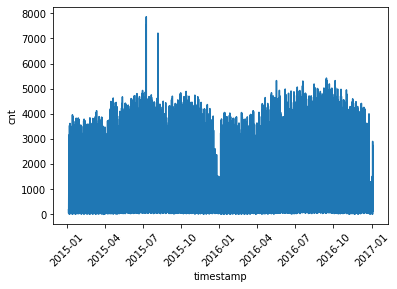

In [20]:
plt.xticks(rotation=45)
sns.lineplot(x='timestamp',y='cnt',data=london)

### Агрегируйте число поездок по дням и визуализируйте результат.

In [40]:
london = london.sort_values('timestamp')

In [45]:
london_timestamp = london.set_index('timestamp')
london_timestamp

cnt   t1   t2    hum  wind_speed  weather_code  \
timestamp                                                              
2015-01-04 00:00:00   182  3.0  2.0   93.0         6.0           3.0   
2015-01-04 01:00:00   138  3.0  2.5   93.0         5.0           1.0   
2015-01-04 02:00:00   134  2.5  2.5   96.5         0.0           1.0   
2015-01-04 03:00:00    72  2.0  2.0  100.0         0.0           1.0   
2015-01-04 04:00:00    47  2.0  0.0   93.0         6.5           1.0   
...                   ...  ...  ...    ...         ...           ...   
2017-01-03 19:00:00  1042  5.0  1.0   81.0        19.0           3.0   
2017-01-03 20:00:00   541  5.0  1.0   81.0        21.0           4.0   
2017-01-03 21:00:00   337  5.5  1.5   78.5        24.0           4.0   
2017-01-03 22:00:00   224  5.5  1.5   76.0        23.0           4.0   
2017-01-03 23:00:00   139  5.0  1.0   76.0        22.0           2.0   

                     is_holiday  is_weekend  season  
timestamp                                            
2015-01-04 00:00:00         0.0         1.0     3.0  
2015-01-04 01:00:00         0.0         1.0     3.0  
2015-01-04 02:00:00         0.0         1.0     3.0  
2015-01-04 03:00:00         0.0         1.0     3.0  
2015-01-04 04:00:00         0.0         1.0     3.0  
...                         ...         ...     ...  
2017-01-03 19:00:00         0.0         0.0     3.0  
2017-01-03 20:00:00         0.0         0.0     3.0  
2017-01-03 21:00:00         0.0         0.0     3.0  
2017-01-03 22:00:00         0.0         0.0     3.0  
2017-01-03 23:00:00         0.0         0.0     3.0  

[17414 rows x 9 columns]

In [47]:
london_timestamp_sum = london_timestamp.resample(rule='D').cnt.sum()

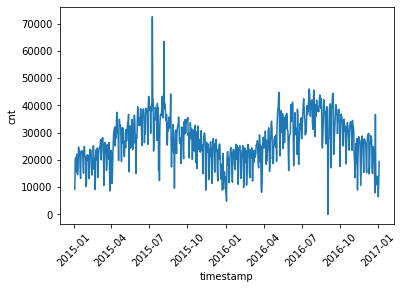

In [50]:
plt.xticks(rotation=45)
sns.lineplot(data = london_timestamp_sum)

### Итак, вы обнаружили на графике некоторые скачки. Давайте проверим, что же могло произойти в тот день 🤔.

### Для этого разделим дальнейшие действия на несколько этапов:

### сначала посчитаем скользящее среднее, чтобы сгладить ряд
### далее – разницу между наблюдаемыми и сглаженными значениями
### определим верхние и нижние границы 99% доверительного интервала 
### найдем причины аномалий!
### На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. 

In [57]:
london_timestamp_rolling_avg = london_timestamp_sum.rolling(window=3).mean().reset_index()

In [63]:
london_timestamp_rolling_avg.query('timestamp =="2015-07-09"').cnt

186    50705.0
Name: cnt, dtype: float64

In [64]:
london_timestamp_sum.reset_index().query('timestamp =="2015-07-09"').cnt

186    72504
Name: cnt, dtype: int64

### Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

### upper_bound – верхняя граница; к средним прибавляем 2.576∗std
### lower_bound – нижняя граница; вычитаем 2.576∗std

In [75]:
c = london_timestamp_sum.reset_index().cnt - london_timestamp_rolling_avg.cnt

In [80]:
std = np.std(c)

In [81]:
std*2.576

11742.919187519814

In [83]:
london_timestamp_rolling_avg['upper_bound'] = london_timestamp_rolling_avg.cnt + (std*2.576)

In [84]:
london_timestamp_rolling_avg['lower_bound'] = london_timestamp_rolling_avg.cnt - (std*2.576)

In [86]:
london_timestamp_rolling_avg.tail(1)

timestamp      cnt   upper_bound  lower_bound
730 2017-01-03  12560.0  24302.919188   817.080812

In [89]:
london_timestamp_rolling_avg = london_timestamp_rolling_avg.rename(columns={'cnt':'rolling_avg_cnt'})

In [94]:
london_timestamp_rolling_avg['cnt'] = london_timestamp_sum.reset_index().cnt

In [100]:
london_timestamp_rolling_avg.dropna().query('cnt > upper_bound')

timestamp  rolling_avg_cnt   upper_bound   lower_bound    cnt
186 2015-07-09     50705.000000  62447.919188  38962.080812  72504
214 2015-08-06     46627.333333  58370.252521  34884.414146  63468
609 2016-09-04     14259.000000  26001.919188   2516.080812  27512
721 2016-12-25     19650.666667  31393.585854   7907.747479  36653

### 2015-07-09 В Лондоне забастовка метрополитена и транспортный колапс.

In [101]:
london_timestamp_rolling_avg.dropna().query('cnt < lower_bound')

timestamp  rolling_avg_cnt   upper_bound   lower_bound    cnt
130 2015-05-14     28709.333333  40452.252521  16966.414146  15609
189 2015-07-12     36036.666667  47779.585854  24293.747479  23240
201 2015-07-24     31013.666667  42756.585854  19270.747479  16034
232 2015-08-24     29529.333333  41272.252521  17786.414146  17400
314 2015-11-14     21037.333333  32780.252521   9294.414146   8898
607 2016-09-02     26086.333333  37829.252521  14343.414146      0
615 2016-09-10     31262.000000  43004.919188  19519.080812  17080
621 2016-09-16     36193.333333  47936.252521  24450.414146  21967
678 2016-11-12     20878.000000  32620.919188   9135.080812   8990

### 2016-09-02 системная ошибка сбора данных